In [1]:
import cv2
from PIL import Image
import numpy as np
import h5py

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint
from keras import backend as keras

import matplotlib.pyplot as plt

In [3]:
def unet(input_size = (256, 256, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                                               kernel_initializer = 'he_normal'
                                               )(inputs)
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                                               kernel_initializer = 'he_normal'
                                               )(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv3)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(conv4)
    
    drop4 = Dropout(0.5)(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                                                 kernel_initializer = 'he_normal'
                                                 )(pool4)
    
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                                                 kernel_initializer = 'he_normal'
                                                 )(conv5)
    
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', 
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(drop5))
    
    merge6 = concatenate([drop4,up6])
    
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge6)
    
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv6))
    
    merge7 = concatenate([conv3,up7])
    
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge7)
    
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal'
                                                )(conv7)

    
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv7))
    
    merge8 = concatenate([conv2,up8])
    
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge8)
    
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same',
                                             kernel_initializer = 'he_normal'
                                             )(UpSampling2D(size = (2,2))(conv8))
    
    merge9 = concatenate([conv1,up9])
    
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(merge9)
    
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(conv9)
    
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(conv9)
    
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    
    return model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
with open('gdrive/My Drive/Colab Notebooks/Shakespeare.txt', 'r', encoding='utf-8') as file:
    text = file.read()

In [ ]:
print('*'*30)
print('Loading and preprocessing train data...')
print('*'*30)
file = h5py.File('gdrive/My Drive/Colab Notebooks/Road map masking/Dataset_train.h5', 'r')
imgs_train = file.get('images')
imgs_mask_train = file.get('masks')
imgs_train = np.array(imgs_train)
imgs_mask_train = np.array(imgs_mask_train)

imgs_train = imgs_train.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean
imgs_train /= std

imgs_mask_train = imgs_mask_train.astype('float32')
imgs_mask_train /= 255  # scale masks to [0, 1]

print('*'*30)
print('Creating and compiling model...')
print('*'*30)
model = unet()
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)
#tensorboard = TensorBoard(log_dir='tensorboard/', write_graph=True, write_images=True)

******************************
Loading and preprocessing train data...
******************************
******************************
Creating and compiling model...
******************************


In [ ]:
model_checkpoint = ModelCheckpoint('gdrive/My Drive/Colab Notebooks/Road map masking/weights.h5', monitor='val_loss', save_best_only=True)

In [5]:
#model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
print('*'*30)
print('Fitting model...')
print('*'*30)
history =  model.fit(imgs_train, imgs_mask_train, batch_size=16, epochs=50, verbose=1, shuffle=True,
          validation_split=0.2,
          callbacks=[model_checkpoint])

******************************
Fitting model...
******************************
Epoch 1/50
108/108 [==============================] - 121s 1s/step - loss: 1.1212 - accuracy: 0.8965 - val_loss: 0.6537 - val_accuracy: 0.8841
Epoch 2/50
108/108 [==============================] - 108s 1000ms/step - loss: 0.6335 - accuracy: 0.8987 - val_loss: 0.6181 - val_accuracy: 0.8841
Epoch 3/50
108/108 [==============================] - 108s 996ms/step - loss: 0.5982 - accuracy: 0.8987 - val_loss: 0.5862 - val_accuracy: 0.8841
Epoch 4/50
108/108 [==============================] - 107s 993ms/step - loss: 0.5667 - accuracy: 0.8987 - val_loss: 0.5578 - val_accuracy: 0.8841
Epoch 5/50
108/108 [==============================] - 107s 994ms/step - loss: 0.5385 - accuracy: 0.8986 - val_loss: 0.5326 - val_accuracy: 0.8841
Epoch 6/50
108/108 [==============================] - 107s 995ms/step - loss: 0.5134 - accuracy: 0.8987 - val_loss: 0.5102 - val_accuracy: 0.8841
Epoch 7/50
108/108 [===========================

In [ ]:
file = h5py.File('gdrive/My Drive/Colab Notebooks/Road map masking/Dataset_test.h5', 'r')
imgs_test = file.get('images')
#imgs_mask_test = file.get('masks')

img1 = cv2.imread("gdrive/My Drive/Colab Notebooks/Road map masking/map4.png")

imgs_test = np.array(img1)#imgs_test)

imgs_test = np.expand_dims(imgs_test, 0)

#imgs_mask_test = np.array(imgs_mask_test)
imgs_test = imgs_test.astype('float32')
imgs_test -= mean
imgs_test /= std

print('*'*30)
print('Loading saved weights...')
print('*'*30)
model.load_weights('weights.h5')

print('*'*30)
print('Predicting masks on test data...')
print('*'*30)
imgs_mask_test = model.predict(imgs_test, verbose=1)

******************************
Loading saved weights...
******************************
******************************
Predicting masks on test data...
******************************
1/1 [==============================] - 0s 38ms/step


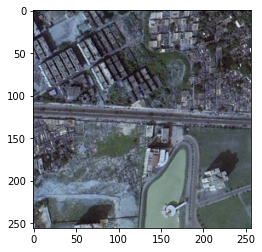

In [ ]:
#img1= np.expand_dims(img1, 0)
img1.shape
plt.imshow(img1[:,:,:])
plt.show()

******************************
Saving predicted masks to files...
******************************
(256, 256, 1)


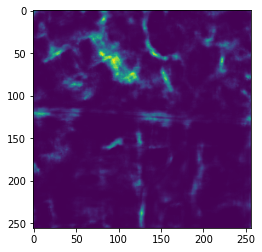

In [ ]:
print('*' * 30)
print('Saving predicted masks to files...')
print('*' * 30)
pred_dir = 'gdrive/My Drive/Colab Notebooks/Road map masking/Pred_map'

for i, image in enumerate(imgs_mask_test):
    image = (image * 255).astype(np.uint8)
    img = image
    cv2.imwrite((pred_dir+ str(i + 1) + '_pred.png'), image)

print(img.shape)
plt.imshow(img[:,:,0])
plt.show()

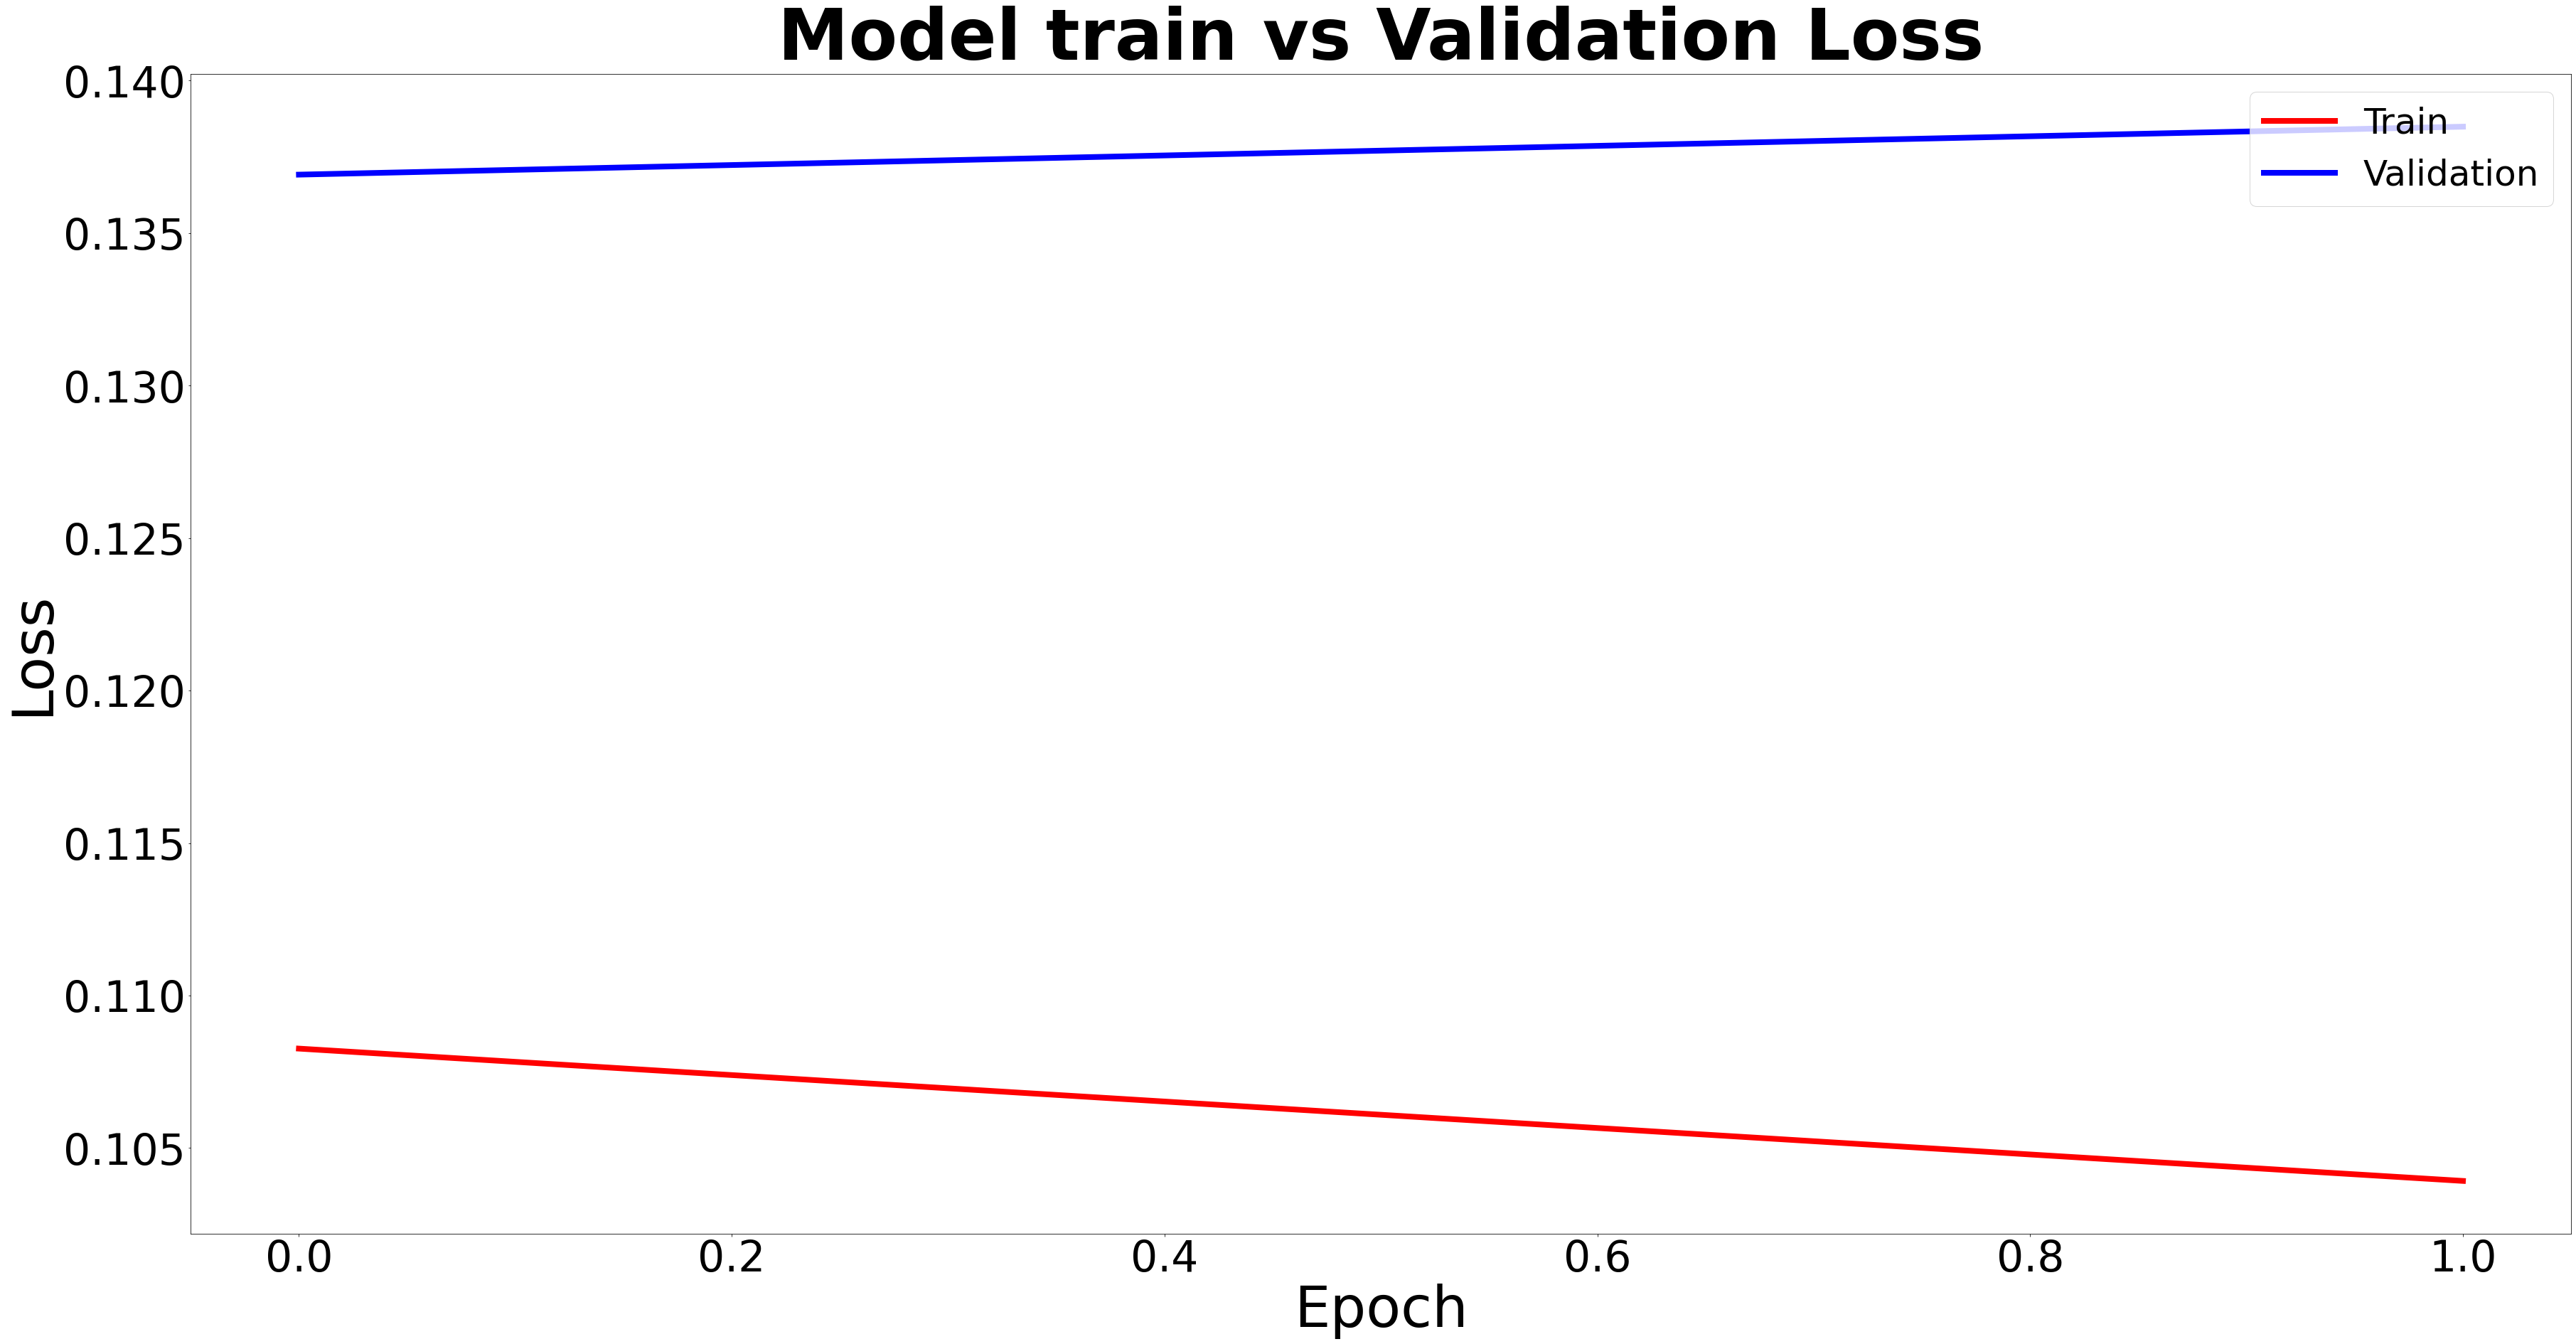

In [ ]:
plt.figure(figsize=(60, 30))
plt.plot(history.history['loss'], linewidth=8, color='r')                   #visualising training and validation loss curves
plt.plot(history.history['val_loss'], linewidth=8, color='b')
plt.title('Model train vs Validation Loss', fontsize=100, fontweight="bold")
plt.ylabel('Loss', fontsize=80)
plt.xlabel('Epoch', fontsize=80)
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=50)
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.show()